# Custom Basis Function Example

Example created by Wilson Rocha Lacerda Junior

In this notebook we show how to plug a custom basis function into SysIdentPy by extending `BaseBasisFunction`. The goal is to highlight that any numpy/scipy/sklearn powered transformation can become a drop-in replacement for the built-in basis functions.

### Requirements

Use the same environment suggested for the other notebooks or install the minimum set:

```
sysidentpy
numpy==1.26.0
matplotlib==3.8.4
```

```bash
pip install -r requirements.txt
```

- The example runs entirely on CPU.
- No additional datasets are required.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.plotting import plot_results
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.basis_function.basis_function_base import BaseBasisFunction

## Synthetic dataset

We simulate a simple SISO system with strong sinusoidal nonlinearities driven by the input signal. The training window contains the first 1600 samples and the remainder is used for validation.

In [13]:
x_train, x_valid, y_train, y_valid = get_siso_data(
    n=1000, colored_noise=False, sigma=0.0001, train_percentage=50
)

## Creating a custom basis function

Our `HarmonicBasis` inherits from `BaseBasisFunction` (see `sysidentpy/basis_function/basis_function_base.py`). The class only needs to implement `fit` and `transform`. Internally we build a matrix with the raw signals plus sine and cosine transforms for the requested harmonics.

In [14]:
class HarmonicBasis(BaseBasisFunction):
    """Map lagged regressors to sine/cosine features."""

    def __init__(self, harmonics=(1,), include_linear=True, scale=np.pi):
        super().__init__(degree=1)
        self.harmonics = tuple(harmonics)
        self.include_linear = include_linear
        self.scale = scale

    def _build_matrix(self, data, predefined_regressors):
        features = []
        if self.include_linear:
            features.append(data)
        for harmonic in self.harmonics:
            scaled = self.scale * harmonic * data
            features.append(np.sin(scaled))
            features.append(np.cos(scaled))
        if not features:
            raise ValueError("The basis needs at least one active transformation.")
        psi = np.hstack(features)
        if predefined_regressors is not None:
            idx = np.asarray(predefined_regressors, dtype=int)
            psi = psi[:, idx]
        return psi

    def fit(
        self,
        data,
        max_lag=1,
        ylag=1,
        xlag=1,
        model_type="NARMAX",
        predefined_regressors=None,
    ):
        psi = self._build_matrix(data, predefined_regressors)
        return psi[max_lag:, :]

    def transform(
        self,
        data,
        max_lag=1,
        ylag=1,
        xlag=1,
        model_type="NARMAX",
        predefined_regressors=None,
    ):
        return self.fit(data, max_lag, ylag, xlag, model_type, predefined_regressors)

## Training with the custom basis

The new basis can be passed directly to `FROLS`. We keep the workflow identical to any other example, changing only the `basis_function` argument.

In [15]:
basis_function = HarmonicBasis(harmonics=(1, 2, 3), include_linear=True, scale=np.pi)

model = FROLS(
    ylag=2,
    xlag=2,
    order_selection=True,
    n_info_values=20,
    info_criteria="aic",
    estimator=LeastSquares(),
    basis_function=basis_function,
    model_type="NARMAX",
)

model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)

rrse = root_relative_squared_error(y_valid[model.max_lag:], yhat[model.max_lag:])
print(f"RRSE (validation): {rrse:.4f}")

RRSE (validation): 0.0608


/Users/wilsonrocha/Documents/RD/projects/sysidentpy/sysidentpy/parameter_estimation/estimators.py:95: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  check_linear_dependence_rows(psi)


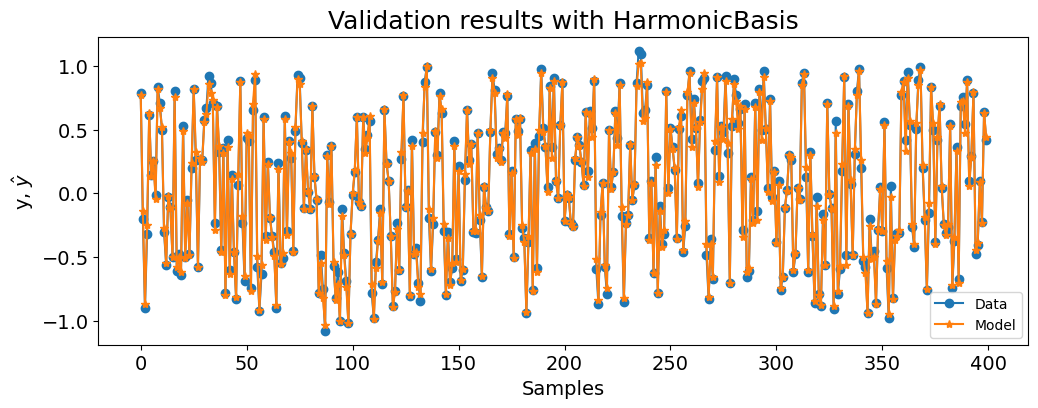

In [16]:
plot_results(
    y=y_valid[model.max_lag:],
    yhat=yhat[model.max_lag:],
    n=400,
    figsize=(12, 4),
    title="Validation results with HarmonicBasis",
)

With just a few lines we created a fully compatible basis function. You can port any numpy/scipy/sklearn transformation into a class like `HarmonicBasis` and reuse it across every SysIdentPy estimator without modifying the rest of the workflow.